## METHODES DES DIFFERENCES FINIES POUR LES OPTIONS EUROPEENNES

Dans ce travail, on cherche une apporximation numérique de la fonction de prix d'un Put européen définie par : $\ v = v(t, s) \ $, $\ t \in [0, T] \ $, $\ s \in [0, S_{\text{max}}] \ $. Cette fonction satisfait l'EDP de Black Scholes définie sur le domaine  $\ \Omega = [S_{\text{min}}, S_{\text{max}}] \ $ comme suit :


\begin{cases}
\frac{\partial v}{\partial t} - \frac{\sigma^2}{2} s^2 \frac{\partial^2 v}{\partial s^2} - rs \frac{\partial v}{\partial s} + rv = 0, & t \in (0, T), s \in (S_{\text{min}}, S_{\text{max}}), \\
v(t, S_{\text{min}}) = v_\ell(t) \equiv Ke^{-rt} - S_{\text{min}}, & t \in (0, T), \\
v(t, S_{\text{max}}) = v_r(t) \equiv 0, & t \in (0, T), \\
v(0, s) = \phi(s) := (K - s)^+, & s \in (S_{\text{min}}, S_{\text{max}}).
\end{cases}

Dans la suite suppose que : $\ K = 100,  S_{\text{min}} = 0,  S_{\text{max}} = 200,  \sigma = 0.2,  r=0.1 \ $

Sur le domaine considéré, on considère le maillage ci-après. On pose $\ h := \frac{S_{\text{max}} - S_{\text{min}}}{I+1} \ $ et $\ \Delta t := \frac{T}{N} \ $, et  

\begin{cases}
s_j := S_{\text{min}} + jh, \quad j = 0, \dots, I+1 \quad \text{(maillage spaciale)} \\
t_n = n\Delta t, \quad n = 0, \dots, N \quad \text{(maillage en temps)}
\end{cases}

On cherche $\ U^n_j \ $, une approximation de $\ v(t_n, s_j) \ $. En particulier, on souhaite évaluer $\ v(t, s) \ $ au temps terminal $\ t = T \ $ pour ce faire on aura recours à plusieurs méthodes de différences finies.

In [1]:
#importation des librairies
import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.stats import norm
import time 
import sys

In [2]:
# Paramètres financiers globaux
r, sigma, K, T = 0.1, 0.2, 100, 1
Smin, Smax = 0, 200

### 1-SCHEMA D'EULER EXPLICITE
Dans un premier temps, on a recours au schéma d'euler explicite qui se décline comme suit : 
\begin{cases}
\frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{\sigma^2}{2} s_j^2 \frac{-U^n_{j-1} + 2U^n_j - U^n_{j+1}}{h^2} - r s_j \frac{U^n_{j+1} - U^n_{j-1}}{2h} + r U^n_j = 0  , \quad n = 0, \dots, N-1, \quad j = 1, \dots, I \\ 
U^n_0 = v_\ell(t_n) \equiv K e^{-r t_n} - S_{\text{min}}, \quad n = 0, \dots, N  \\
U^n_{I+1} = v_r(t_n) \equiv 0, \quad n = 0, \dots, N  \\
U^0_j = \phi(s_j) \equiv (K - s_j)^+, \quad j = 1, \dots, I 
\end{cases}

On choisit de travailler avec le vecteur inconnu $\ (v(t_n, s_j))_{j=1,\dots,I} \ $ :
$\
U^n =
\begin{pmatrix}
U^n_1 \\
\vdots \\
U^n_I
\end{pmatrix}.
\ $
On réécrit le système d'équation précédent sous forme matricielle comme suit : 

\begin{cases}
\frac{U^{n+1} - U^n}{\Delta t} + A U^n + q(t_n) = 0, \quad n = 0, \dots, N-1 \\
U^0 = (\phi(s_i))_{1 \leq i \leq I}
\end{cases}

On pose $\alpha_j := \frac{\sigma^2}{2} \frac{s_j^2}{h^2}, \quad \beta_j := \frac{r s_j}{2h}. \ $ On cherche alors $\ A \ $ et $\ q(t) \ $ tels que : $\alpha_i(-U^n_{i-1} + 2U^n_i - U^n_{i+1}) - \beta_i(U^n_{i+1} - U^n_{i-1}) + r U^n_i
= (-\alpha_i + \beta_i)U^n_{i-1} + (2\alpha_i + r)U^n_i + (-\alpha_i - \beta_i)U^n_{i+1}
\equiv (AU + q(t_n))_i. \ $

Par identification, on a : 
$\
A :=
\begin{bmatrix}
2\alpha_1 + r & -\alpha_1 - \beta_1 & 0 & \cdots & 0 \\
-\alpha_2 + \beta_2 & 2\alpha_2 + r & -\alpha_2 - \beta_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & -\alpha_I + \beta_I & 2\alpha_I + r
\end{bmatrix}.
\ $

Et $\ q(t_n) \ $ contient les valeurs aux bornes $\ U^n_0 = v_\ell(t_n) \ $ et $\ U^n_{I+1} = v_r(t_n) \ $ et est défini comme suit :
\begin{cases}
q(t_n) :=
\begin{pmatrix}
(-\alpha_1 + \beta_1)U^n_0 \\
0 \\
\vdots \\
0 \\
(-\alpha_I - \beta_I)U^n_{I+1}
\end{pmatrix}
\equiv
\begin{pmatrix}
(-\alpha_1 + \beta_1)v_\ell(t_n) \\
0 \\
\vdots \\
0 \\
(-\alpha_I - \beta_I)v_r(t_n)
\end{pmatrix}.
\end{cases}

Le code ci-dessous est une implémentation du schéma d'Euler explicite. 

In [3]:
# Fonctions utilitaires
def phi(s):
    """Fonction payoff pour une option put européenne."""
    return np.maximum(K - s, 0)
    
def u_left(t):
    """Condition au bord gauche."""
    return K * np.exp(-r * t) - Smin

def u_right(t):
    """Condition au bord droit."""
    return 0

In [4]:
def explicit_euler(N, I):
    """
    Implémente le schéma d'Euler explicite pour l'équation de Black-Scholes.
    Paramètres:
        N (int): Nombre de pas de temps.
        I (int): Nombre de points spatiaux. 
    Retourne:
        s (array): Maillage spatial.
        U (array): Solution numérique à t = T.
        A (matrice)
    """
    # Calcul des pas
    h = (Smax - Smin) / (I + 1)
    dt = T / N
    
    # Maillage
    s = Smin + h * np.arange(1, I + 1)  # points s_1, ..., s_I
    
    # Initialisation de U
    U = phi(s).reshape(I, 1)

    # Matrice A
    alpha = (sigma**2 / 2) * (s**2 / h**2)
    beta = r * s / (2 * h)
    A = np.zeros((I, I))
    for i in range(I):
        if i > 0:
            A[i, i-1] = -alpha[i] + beta[i]
        A[i, i] = 2 * alpha[i] + r
        if i < I - 1:
            A[i, i+1] = -alpha[i] - beta[i]

    # Fonction q(t)
    def q(t):
        q_vec = np.zeros((I, 1))
        q_vec[0] = (-alpha[0] + beta[0]) * u_left(t)
        q_vec[-1] = (-alpha[-1] - beta[-1]) * u_right(t)
        return q_vec

    # Boucle temporelle pour le schéma d'Euler explicite
    for n in range(N):
        tn = n * dt
        U = U - dt * (A @ U + q(tn))
    #on rajoute le payoff pour Smin et Smax pour compléter le graphique    
    s = s.tolist()
    s.insert(0,Smin)
    s.append(Smax)
    
    U = U.flatten().tolist()
    U.insert(0,u_left(T))
    U.append(0)
    
    return s, U, A

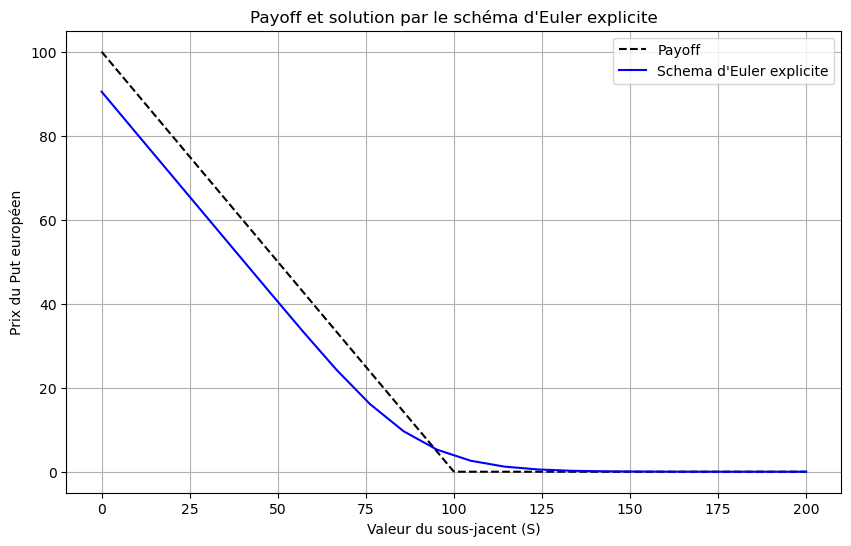

In [5]:
def plot_results(N, I):
    """
    Trace le payoff initial et la solution obtenue avec Euler explicite.
    Paramètres:
        N (int): Nombre de pas de temps.
        I (int): Nombre de points spatiaux.
    """
    # Calcul des résultats avec Euler explicite
    s, U,_ = explicit_euler(N, I)

    #calcul du payoff
    S = np.linspace(Smin, Smax, 500)
    payoff_values = phi(S)
    
    plt.figure(figsize=(10, 6))
    # Tracé du payoff
    plt.plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')

    # Génération du graphique
    plt.plot(s, U, label="Schema d'Euler explicite",color="blue")
    plt.title("Payoff et solution par le schéma d'Euler explicite")
    plt.xlabel("Valeur du sous-jacent (S)")
    plt.ylabel("Prix du Put européen")
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_results(N=20, I=20)

#### 1.1-Tests numériques sur le schéma d'Euler explicite

#### a-1 On fixe N = 10 et on fait varier I = 10, 20, 50, 100

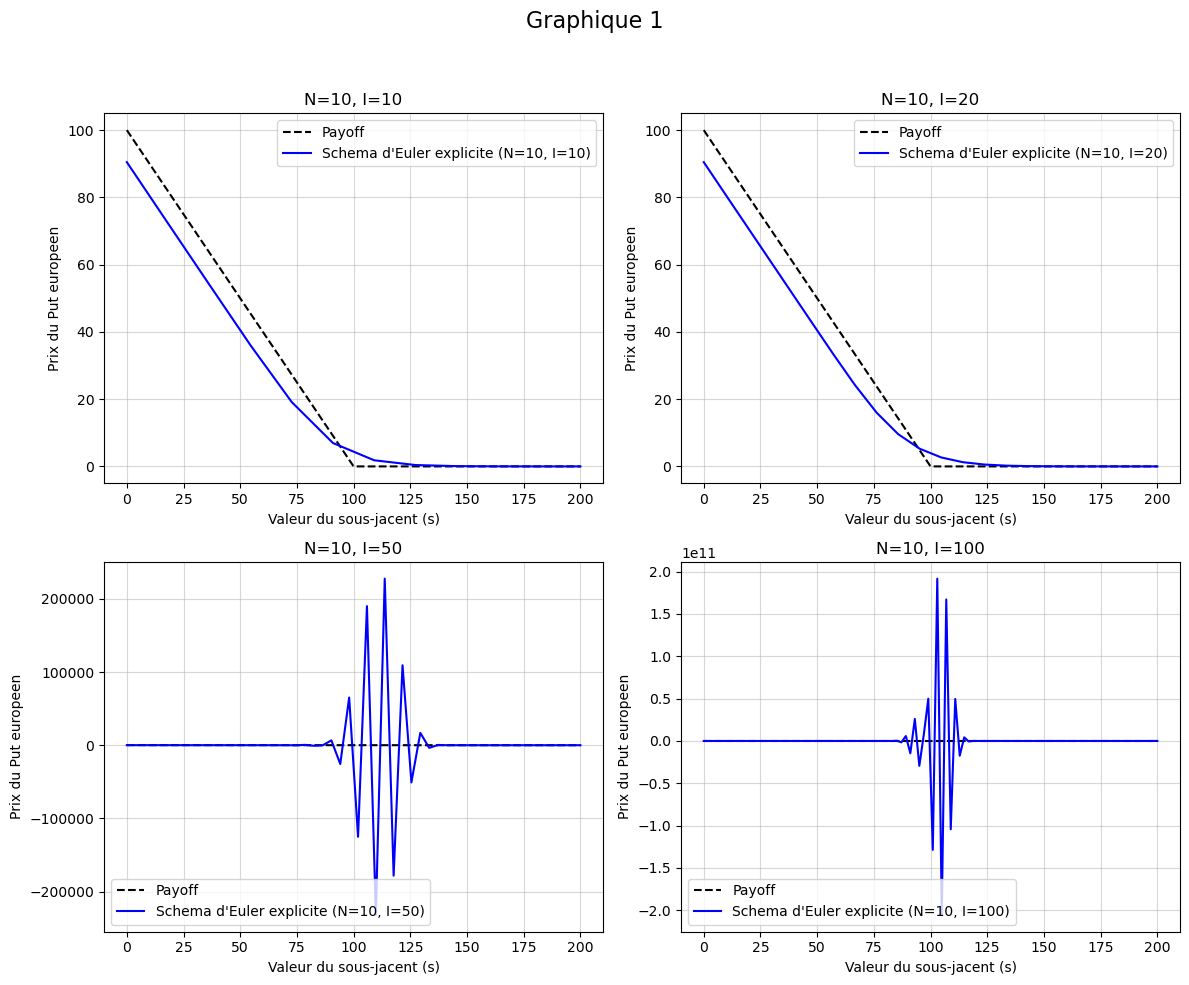

In [6]:
def plot_four_graphs():
    """
    Trace quatre graphiques représentant le payoff et la solution numérique
    pour différentes valeurs de N et I dans une seule figure.
    """
    # Paramètres pour les simulations
    params = [
        (10, 10), 
        (10, 20),  
        (10, 50),
        (10, 100)  
    ]
    
    # Créer la figure et les sous-graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Graphique 1', fontsize=16)
    
    # Générer les graphiques
    for i, (N, I) in enumerate(params):
        row, col = divmod(i, 2)  # Calculer la position (ligne, colonne) dans la grille
        s, U,_ = explicit_euler(N, I)
        
        # Tracé du payoff
        S = np.linspace(Smin, Smax, 500)
        payoff_values = phi(S)
        axs[row, col].plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')
        
        # Tracé de la solution obtenue par Euler explicite
        axs[row, col].plot(s, U, label=f"Schema d'Euler explicite (N={N}, I={I})", color='blue')
        
        # Ajouter des titres, légendes et grilles
        axs[row, col].set_title(f'N={N}, I={I}')
        axs[row, col].grid(alpha=0.5)
        axs[row, col].legend()
        axs[row, col].set_xlabel('Valeur du sous-jacent (s)')
        axs[row, col].set_ylabel('Prix du Put europeen')
    # Ajuster l'espacement
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de la place pour le titre global
    plt.show()

# Exemple d'utilisation
plot_four_graphs()

#### a-2) On fixe N = I et on fait varier I = 10, 20, 50, 100

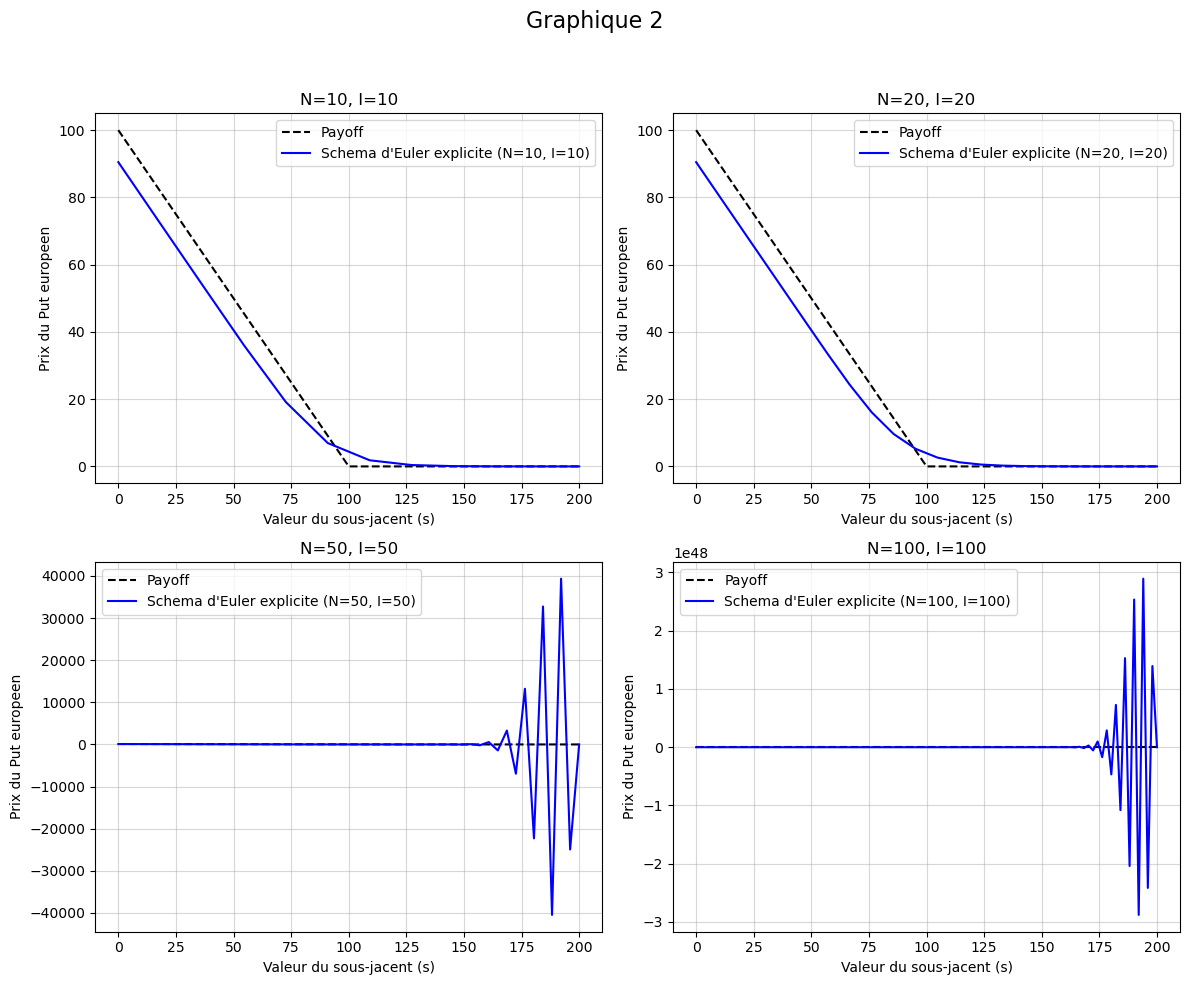

In [7]:
def plot_four_graphs():
    """
    Trace quatre graphiques représentant le payoff et la solution numérique
    pour différentes valeurs de N et I dans une seule figure.
    """
    # Paramètres pour les simulations
    params = [
        (10, 10),   
        (20, 20),  
        (50, 50), 
        (100, 100)  
    ]
    
    # Créer la figure et les sous-graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Graphique 2', fontsize=16)
    
    # Générer les graphiques
    for i, (N, I) in enumerate(params):
        row, col = divmod(i, 2)  # Calculer la position (ligne, colonne) dans la grille
        s, U,_ = explicit_euler(N, I)
        
        # Tracé du payoff
        S = np.linspace(Smin, Smax, 500)
        payoff_values = phi(S)
        axs[row, col].plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')
        
        # Tracé de la solution obtenue par Euler explicite
        axs[row, col].plot(s, U, label=f"Schema d'Euler explicite (N={N}, I={I})", color='blue')
        
        # Ajouter des titres, légendes et grilles
        axs[row, col].set_title(f'N={N}, I={I}')
        axs[row, col].grid(alpha=0.5)
        axs[row, col].legend()
        axs[row, col].set_xlabel('Valeur du sous-jacent (s)')
        axs[row, col].set_ylabel('Prix du Put europeen')
    # Ajuster l'espacement
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de la place pour le titre global
    plt.show()

# Exemple d'utilisation
plot_four_graphs()

**Commentaire:** On observe grâce aux graphiques 1 et 2 que le schéma d'Euler explicite n'est pas numéricalement stable. En effet, après un nombre fini d'itérations on remarque que la norme du vecteur des approximations $\ U^n \ $ explose. Aussi  $\ U^n_j \ $ (l'approximation de $\ v(t_n, s_j) \ $) n'a pas toujours des valeurs positives, ce que l'on souhaiterait éviter. Aussi, en regardant le graphique 1, on conclut que lorsque le nombre de pas de temps est faible (petite valeur de N), à mesure que le maillage en espace comporte plus de points (I grand) le schéma d'Euler explicite devient instable. Le graphique 2 montre que l'instabilité persiste quand N et I évoluent en étant égaux. Il semble nécessaire lorsque I augmente de considérer des valeurs de N beaucoup plus importantes. Le schéma d'euler explicite semble nécessiter un maillage plus fin en temps pour être stable numériquement.

#### b) Compréhension de l'origine des oscillations et des explosions observées
Pour ce faire, on va s'intéresser à la matrice d'amplification définie comme suit  : $B := I_d - \Delta tA $. On sait que le schéma d'Euler peut être programmé en utilisant l'équation récursive ci-après : $U^{n+1} = U^n - \Delta t (A U^n + q(t_n)) $. Cette équation peut être réécrite sous la forme suivante : $U^{n+1} = (I_d - \Delta tA)U^n + \Delta tq(t_n)) = BU^n + \Delta tq(t_n)) $. On comprend que toute oscillation ou explosion dans les approximations est due à la matrice $B $. 

#### Premier cas N=10 ert I=50

In [8]:
#On récupére la matrice A pour ces valeurs de N et I
_, _, A = explicit_euler(10, 50)
I_d = np.eye(50)
B = I_d - (1/10)*A
#On extrait ensuite la diagonale de B 
np.diag(B)

array([ 0.986,  0.974,  0.954,  0.926,  0.89 ,  0.846,  0.794,  0.734,
        0.666,  0.59 ,  0.506,  0.414,  0.314,  0.206,  0.09 , -0.034,
       -0.166, -0.306, -0.454, -0.61 , -0.774, -0.946, -1.126, -1.314,
       -1.51 , -1.714, -1.926, -2.146, -2.374, -2.61 , -2.854, -3.106,
       -3.366, -3.634, -3.91 , -4.194, -4.486, -4.786, -5.094, -5.41 ,
       -5.734, -6.066, -6.406, -6.754, -7.11 , -7.474, -7.846, -8.226,
       -8.614, -9.01 ])

In [9]:
lng.norm(B, np.inf)

18.218000000000004

In [10]:
lng.norm(B, 2)

16.473976044293305

**Commentaire:** En se restreignant à la diagonale de la matrice pour ces valeurs de N et de I, on observe que les coefficients de celle-ci ne sont pas tous positifs et que plusieurs des éléments diagonaux sont en valeur absolue supérieur à 1. Ces coefficients négatifs et la norme élevée de la matice explique les oscillations observées au graphique 1.  

#### Deuxième cas N=10 ert I=10

In [11]:
_, _, A = explicit_euler(10, 10)
I_d = np.eye(10)
B = I_d - (1/10)*A
B

array([[ 0.986,  0.007,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [-0.002,  0.974,  0.018,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.003,  0.954,  0.033,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.012,  0.926,  0.052,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.025,  0.89 ,  0.075,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.042,  0.846,  0.102,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.063,  0.794,  0.133,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.088,  0.734,
         0.168,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.117,
         0.666,  0.207],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.15 ,  0.59 ]])

**Commentaire:** On observe que dans ce cas-ci la matrice d'amplification a ses coefficients qui sont presques tous positifs et de valeur abolue inférieure à 1. On remarque aussi que dans ce cas le schéma d'Euler se comporte bien.  

#### c) Calcul des valeurs CFL 
Elles sont définies par :  $\mu := \frac{\Delta t}{h^2}\sigma^2 S^2_{max} $

In [12]:
# Pour N = 10 et I = 10
N, I = 10, 10
mu1 = (T/N)*(1/((Smax-Smin)/(I+1)))*(sigma**2)*(Smax**2)
mu1

8.8

In [13]:
# Pour N = 10 et I = 50
N, I = 10, 50
mu2 = (T/N)*(1/((Smax-Smin)/(I+1)))*(sigma**2)*(Smax**2)
mu2

40.80000000000001

**Commentaire:** En comparant ces deux valeurs, on constate que dans le premier cas, la valeur CFL est faible. Il s'agit aussi du cas où le schema d'Euler explicite se comporte bien. On en déduit que plus le CFL est petit plus le schéma est stable.  

#### d) et e) Ordre du schéma d'Euler Explicite.

In [14]:
S_val = 80  # Point d'interpolation pour le tableau

# Formule de Black-Scholes pour le put européen
def black_scholes_put(S, K, T, r, sigma):
    """Formule analytique pour le put européen"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Fonction pour l'interpolation linéaire
def interpolate(s, U, I, S_val):
    """Interpolation linéaire pour trouver U(S_val)"""
    h = (Smax - Smin) / (I + 1)
    for i in range(len(s) - 1):
        if s[i] <= S_val <= s[i + 1]:
            return ((s[i + 1] - S_val) / h) * U[i] + ((S_val - s[i]) / h) * U[i + 1]
    return None  # S_val est hors du domaine

# Liste des valeurs I pour l'expérience
I_values = [10, 20, 40, 80, 160, 320]
table = []

# Calcul des valeurs et erreurs avec temps d'exécution (tcpu)
for I in I_values:
    N = I**2 // 10

    # Mesure du temps d'exécution pour explicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = explicit_euler(N, I)  # Appel de explicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout de tcpu au tableau

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

I         N         U(s)                errex               tcpu                alpha               error               
10        10        14.255092           0.981429            0.000232            N/A                 N/A                 
20        40        13.547634           0.273971            0.000599            1.973300            0.707459            
40        160       13.345106           0.071443            0.001667            2.009007            0.202528            
80        640       13.291930           0.018267            0.006861            2.002965            0.053175            
160       2560      13.278284           0.004621            0.054296            2.000790            0.013646            
320       10240     13.274825           0.001162            0.819943            2.000216            0.003459            


**Commentaire:** Le tableau ci-dessus permet de voir que le schema d'Euler explicite présente une certaine stabilité à mesure que I et N évolue (avec N proportionnel au carré de I). Les valeurs de alpha montre aussi que ce schéma est d'ordre 2 en la variable s . 

### 2-SCHEMA D'EULER Implicite
De ce qui précède on a vu que le schéma d'Euler explicite présente une instabilité numérique en fonction maillage considéré. On observe en effet, une explosion et des oscillations dans les résultats de ce schéma dû à la matrice d'amplification. On a constaté que l'instabilité pouvait être corrigée en considérant N et I tels que N soit proportionnel au carré de I. Toutefois, une telle approche est très coûteuse en termes d'itérations. Pour y rémédier on va donc implémenter le schéma d'Euler implicite qui est définit de façon récursive par les équations ci-après : 
\begin{cases}
\frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{\sigma^2}{2} s_j^2 \frac{-U^{n+1}_{j-1} + 2U^{n+1}_j - U^{n+1}_{j+1}}{h^2} - r s_j \frac{U^{n+1}_{j+1} - U^{n+1}_{j-1}}{2h} + r U^{n+1}_j = 0  , \quad n = 0, \dots, N-1, \quad j = 1, \dots, I \\ 
U^{n+1}_0 = v_\ell(t_{n+1}) \equiv K e^{-r t_{n+1}} - S_{\text{min}}, \quad n = 0, \dots, N-1  \\
U^n_{I+1} = v_r(t_{n+1}) \equiv 0, \quad n = 0, \dots, N-1  \\
U^0_j = \phi(s_j) \equiv (K - s_j)^+, \quad j = 1, \dots, I 
\end{cases}

On travaille avec le même vecteur inconnu $\ (v(t_n, s_j))_{j=1,\dots,I} \ $ :
$\
U^n =
\begin{pmatrix}
U^n_1 \\
\vdots \\
U^n_I
\end{pmatrix}.
\ $
On peut réécrire le système d'équation sous forme matricielle comme suit : 

\begin{cases}
\frac{U^{n+1} - U^n}{\Delta t} + A U^{n+1} + q(t_{n+1}) = 0, \quad n = 0, \dots, N-1 \\
U^0 = (\phi(s_i))_{1 \leq i \leq I}
\end{cases}

#### a) Stabilité du schéma d'Euler Implicite

In [15]:
def implicit_euler(N, I):
    """
    Implémente le schéma d'Euler implicite pour l'équation de Black-Scholes.
    Paramètres:
        N (int): Nombre de pas de temps.
        I (int): Nombre de points spatiaux. 
    Retourne:
        s (array): Maillage spatial.
        U (array): Solution numérique à t = T.
        A
    """
    # Calcul des pas
    h = (Smax - Smin) / (I + 1)
    dt = T / N

    # Maillage
    s = Smin + h * np.arange(1, I + 1)  # points s_1, ..., s_I

    # Initialisation de U
    U = phi(s).reshape(I, 1)

    # Matrice A
    alpha = (sigma**2 / 2) * (s**2 / h**2)
    beta = r * s / (2 * h)
    A = np.zeros((I, I))
    for i in range(I):
        if i > 0:
            A[i, i-1] = -alpha[i] + beta[i]
        A[i, i] = 2 * alpha[i] + r
        if i < I - 1:
            A[i, i+1] = -alpha[i] - beta[i]

    # Matrice Id - dt * A
    B = np.eye(I) + dt * A

    # Fonction q(t)
    def q(t):
        q_vec = np.zeros((I, 1))
        q_vec[0] = (-alpha[0] + beta[0]) * u_left(t)
        q_vec[-1] = (-alpha[-1] - beta[-1]) * u_right(t)
        return q_vec

    # Boucle temporelle pour le schéma d'Euler implicite
    for n in range(N):
        tn = (n + 1) * dt
        U = solve(B, U - dt * q(tn))

    # Ajouter les conditions aux limites pour compléter le graphique
    s = s.tolist()
    s.insert(0, Smin)
    s.append(Smax)

    U = U.flatten().tolist()
    U.insert(0, u_left(T))
    U.append(0)

    return s, U, A

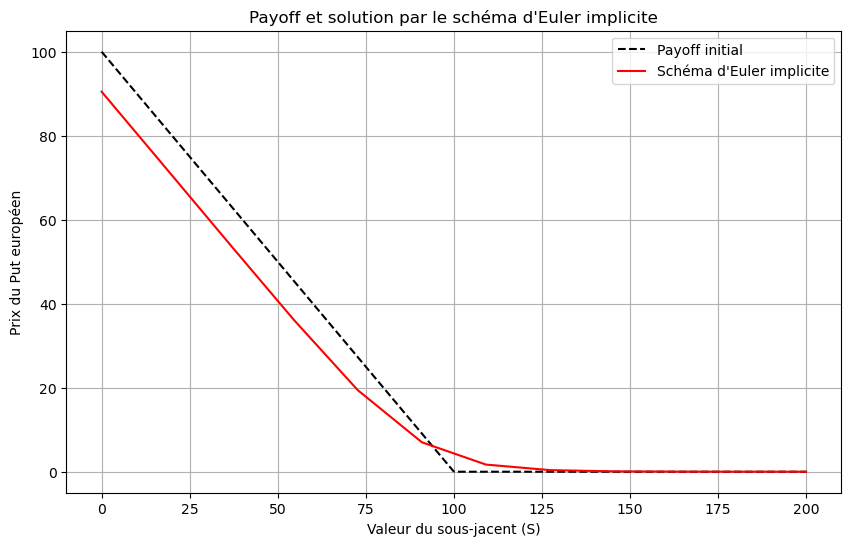

In [16]:
def plot_results_implicit(N, I):
    """
    Trace le payoff initial et la solution obtenue avec Euler implicite.
    Paramètres:
        N (int): Nombre de pas de temps.
        I (int): Nombre de points spatiaux.
    """
    # Calcul des résultats avec Euler implicite
    s, U, _ = implicit_euler(N, I)

    # Calcul du payoff initial
    S = np.linspace(Smin, Smax, 500)
    payoff_values = phi(S)

    # Génération du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(S, payoff_values, label="Payoff initial", color="black", linestyle="--")
    plt.plot(s, U, label="Schéma d'Euler implicite", color="red")
    plt.title("Payoff et solution par le schéma d'Euler implicite")
    plt.xlabel("Valeur du sous-jacent (S)")
    plt.ylabel("Prix du Put européen")
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_results_implicit(10, 10)

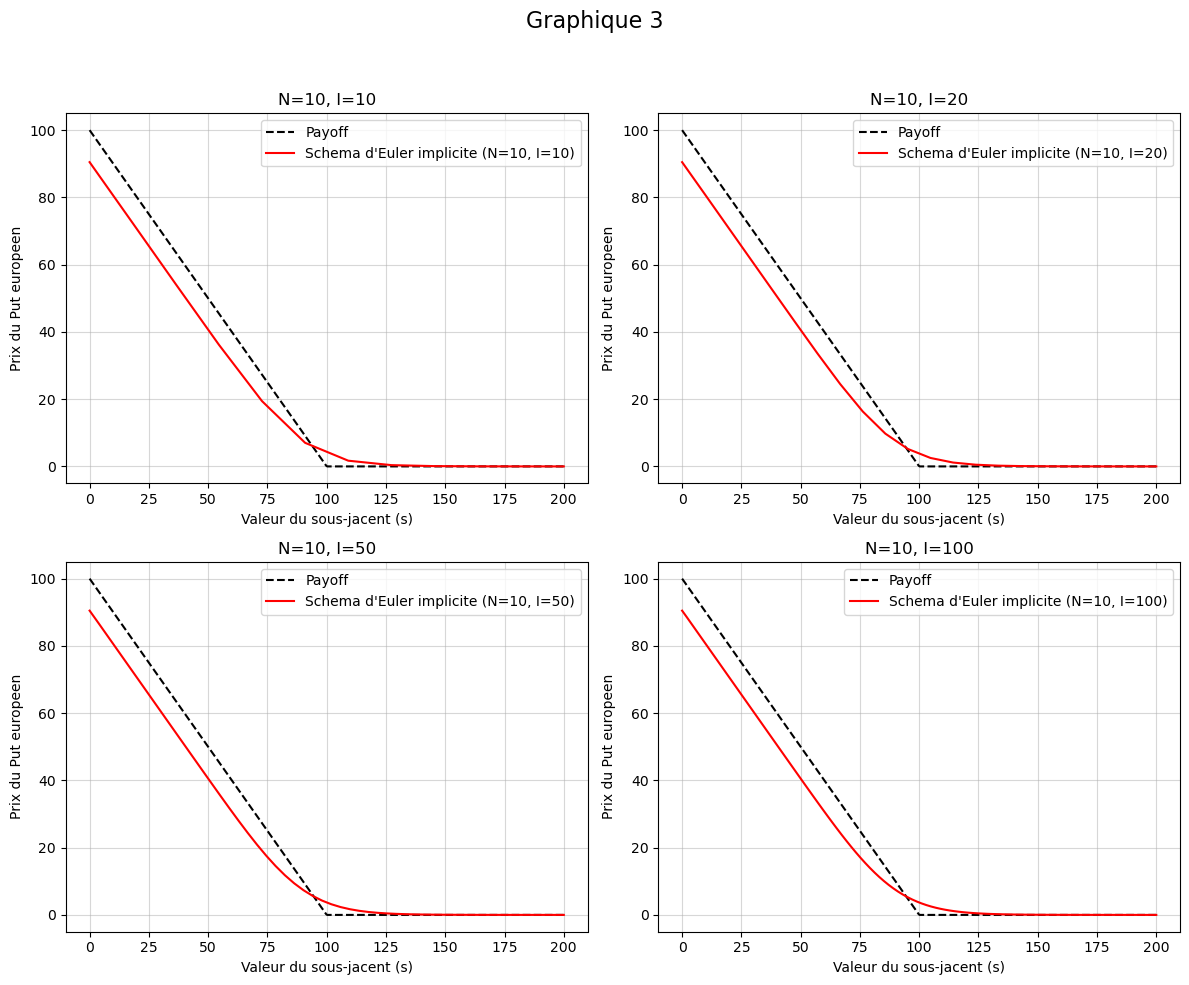

In [17]:
def plot_four_graphs():
    """
    Trace quatre graphiques représentant le payoff et la solution numérique
    pour différentes valeurs de N et I dans une seule figure.
    """
    # Paramètres pour les simulations
    params = [
        (10, 10),   # (N, I)
        (10, 20),  # (N, I)
        (10, 50), # (N, I)
        (10, 100)  # (N, I)
    ]
    
    # Créer la figure et les sous-graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Graphique 3', fontsize=16)
    
    # Générer les graphiques
    for i, (N, I) in enumerate(params):
        row, col = divmod(i, 2)  # Calculer la position (ligne, colonne) dans la grille
        s, U,_ = implicit_euler(N, I)
        
        # Tracé du payoff
        S = np.linspace(Smin, Smax, 500)
        payoff_values = phi(S)
        axs[row, col].plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')
        
        # Tracé de la solution obtenue par Euler explicite
        axs[row, col].plot(s, U, label=f"Schema d'Euler implicite (N={N}, I={I})", color='red')
        
        # Ajouter des titres, légendes et grilles
        axs[row, col].set_title(f'N={N}, I={I}')
        axs[row, col].grid(alpha=0.5)
        axs[row, col].legend()
        axs[row, col].set_xlabel('Valeur du sous-jacent (s)')
        axs[row, col].set_ylabel('Prix du Put europeen')
    # Ajuster l'espacement
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de la place pour le titre global
    plt.show()

# Exemple d'utilisation
plot_four_graphs()

**Commentaire:** Le graphique 3 ci-après permet de constater que le schéma d'Euler implicite ne pose aucun problème de stabilité. En effet, on observe aucune oscillation ou explosion. Le schéma semble bien approcher le payoff du Put européen. 

#### b) Ordre du schéma d'Euler implicite

In [18]:
I_values = [10, 20, 40, 80, 160, 320]
table = []

for I in I_values:
    N = int(I / 10)

    # Mesure du temps d'exécution pour implicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = implicit_euler(N, I)  # Appel de implicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout du temps d'exécution à la table

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

I         N         U(s)                errex               tcpu                alpha               error               
10        1         15.115616           1.841953            0.000740            N/A                 N/A                 
20        2         14.135687           0.862024            0.000415            1.174245            0.979929            
40        4         13.667824           0.394161            0.000437            1.169606            0.467863            
80        8         13.456693           0.183030            0.001181            1.126652            0.211131            
160       16        13.360985           0.087322            0.007708            1.077291            0.095708            
320       32        13.316197           0.042534            0.057984            1.042412            0.044788            


In [19]:
I_values = [10, 20, 40, 80, 160, 320]
table = []

for I in I_values:
    N = I

    # Mesure du temps d'exécution pour implicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = implicit_euler(N, I)  # Appel de implicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout du temps d'exécution à la table

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

I         N         U(s)                errex               tcpu                alpha               error               
10        10        14.448406           1.174743            0.001316            N/A                 N/A                 
20        20        13.642159           0.368496            0.000942            1.792956            0.806247            
40        40        13.386145           0.112482            0.002360            1.773621            0.256015            
80        80        13.310502           0.036839            0.009246            1.639391            0.075642            
160       160       13.287066           0.013403            0.068292            1.471804            0.023436            
320       320       13.279089           0.005426            0.551671            1.310471            0.007977            


**Commentaire:** Les deux tableaux ci-dessus montrent que le schéma d'Euler implicite est stable numériquement. Aussi les résultats du premier suggère qu'il n'est pas nécessaire des valeurs de N proportionnelles au carré de I pour assurer la stabilité du schéma. Toutefois en comparant les colonnes alpha des deux tableaux on peut voir que l'ordre théorique du schéma d'Euler implicite qui est de 2, se précise à mesure ue le maillage en temps s'affine. 

### 3-SCHEMA DE CRANK NICOLSON
On a pu constater que le schéma d'Euler Implicite se comporte plutôt bien. Il est stable numériquement mais l'ordre du schéma se vérifie numériquement pour de grande valeur de N. A présent on s'intéresse au schéma de CRANK NICOLSON qui est définit de façon récursive par les équations ci-après : 
\begin{cases}
\frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{1}{2} (-\frac{\sigma^2}{2} s_j^2 \frac{U^{n+1}_{j-1} - 2U^{n+1}_j + U^{n+1}_{j+1}}{h^2} - r s_j \frac{U^{n+1}_{j+1} - U^{n+1}_{j-1}}{2h} + r U^{n+1}_j) + \frac{1}{2} (-\frac{\sigma^2}{2} s_j^2 \frac{U^{n}_{j-1} - 2U^{n}_j + U^{n}_{j+1}}{h^2} - r s_j \frac{U^{n}_{j+1} - U^{n}_{j-1}}{2h} + r U^{n}_j) = 0  , \quad n = 0, \dots, N-1, \quad j = 1, \dots, I \\ 
U^{n+1}_0 = v_\ell(t_{n+1}) \equiv K e^{-r t_{n+1}} - S_{\text{min}}, \quad n = 0, \dots, N-1  \\
U^n_{I+1} = v_r(t_{n+1}) \equiv 0, \quad n = 0, \dots, N-1  \\
U^0_j = \phi(s_j) \equiv (K - s_j)^+, \quad j = 1, \dots, I 
\end{cases}

On travaille avec le même vecteur inconnu $\ (v(t_n, s_j))_{j=1,\dots,I} \ $ :
$\
U^n =
\begin{pmatrix}
U^n_1 \\
\vdots \\
U^n_I
\end{pmatrix}.
\ $
On peut réécrire le système d'équation sous forme matricielle comme suit : 

\begin{cases}
\frac{U^{n+1} - U^n}{\Delta t} + A (\frac{U^{n+1} + U^{n}}{2}) + q(t_{n+1}) + q(t_{n}) = 0, \quad n = 0, \dots, N-1 \\
U^0 = (\phi(s_i))_{1 \leq i \leq I}
\end{cases}

#### a) Stabilité du schéma

In [20]:
def crank_nicolson(N, I):
    """
    Implémente le schéma de Crank-Nicolson pour l'équation de Black-Scholes.
    
    Paramètres :
        N (int) : Nombre de pas de temps.
        I (int) : Nombre de points spatiaux.
    Retourne :
        s (array) : Maillage spatial.
        U (array) : Solution numérique à t = T.
    """
    # Calcul des pas
    h = (Smax - Smin) / (I + 1)
    dt = T / N

    # Maillage spatial
    s = Smin + h * np.arange(1, I + 1)  # points s_1, ..., s_I


    # Initialisation de U
    U = phi(s).reshape(I, 1)

    # Coefficients pour la matrice tridiagonale
    alpha = (sigma**2 / 2) * (s**2 / h**2)
    beta = r * s / (2 * h)

    # Matrice A (pour t = n+1) et B (pour t = n)
    A = np.zeros((I, I))
    B = np.zeros((I, I))

    for i in range(I):
        if i > 0:
            A[i, i-1] = -alpha[i] + beta[i]
        A[i, i] = 2 * alpha[i] + r
        if i < I - 1:
            A[i, i+1] = -alpha[i] - beta[i]
            
    # Matrice Id - dt * A
    B = np.eye(I) - (dt/2) * A 
    C = np.eye(I) + (dt/2) * A 
    
    # Fonction q(t)
    def q(t):
        q_vec = np.zeros((I, 1))
        q_vec[0] = 0.5 * (-alpha[0] + beta[0]) * (u_left(t) + u_left(t - dt))
        q_vec[-1] = 0.5 * (-alpha[-1] - beta[-1]) * (u_right(t) + u_right(t - dt))
        return q_vec

    # Boucle temporelle pour le schéma de Crank-Nicolson
    for n in range(N):
        tn = (n + 1) * dt
        rhs = B @ U - dt*q(tn)  # Second membre
        U = solve(C, rhs)  # Résolution du système linéaire

    # Ajouter les conditions aux limites pour compléter le graphique
    s = s.tolist()
    s.insert(0, Smin)
    s.append(Smax)

    U = U.flatten().tolist()
    U.insert(0, u_left(T))
    U.append(0)

    return s, U, A
    

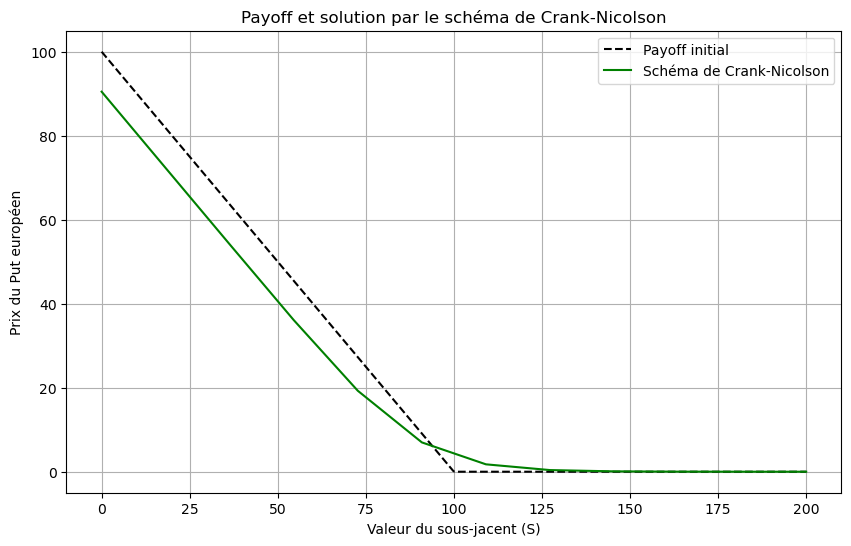

In [21]:
def plot_results_cn(N, I):
    """
    Trace le payoff initial et la solution obtenue avec Crank-Nicolson.
    
    Paramètres :
        N (int) : Nombre de pas de temps.
        I (int) : Nombre de points spatiaux.
    """
    # Calcul des résultats avec Crank-Nicolson
    s, U, _ = crank_nicolson(N, I)

    # Calcul du payoff initial
    S = np.linspace(Smin, Smax, 500)
    payoff_values = phi(S)

    # Génération du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(S, payoff_values, label="Payoff initial", color="black", linestyle="--")
    plt.plot(s, U, label="Schéma de Crank-Nicolson", color="green")
    plt.title("Payoff et solution par le schéma de Crank-Nicolson")
    plt.xlabel("Valeur du sous-jacent (S)")
    plt.ylabel("Prix du Put européen")
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_results_cn(10, 10)

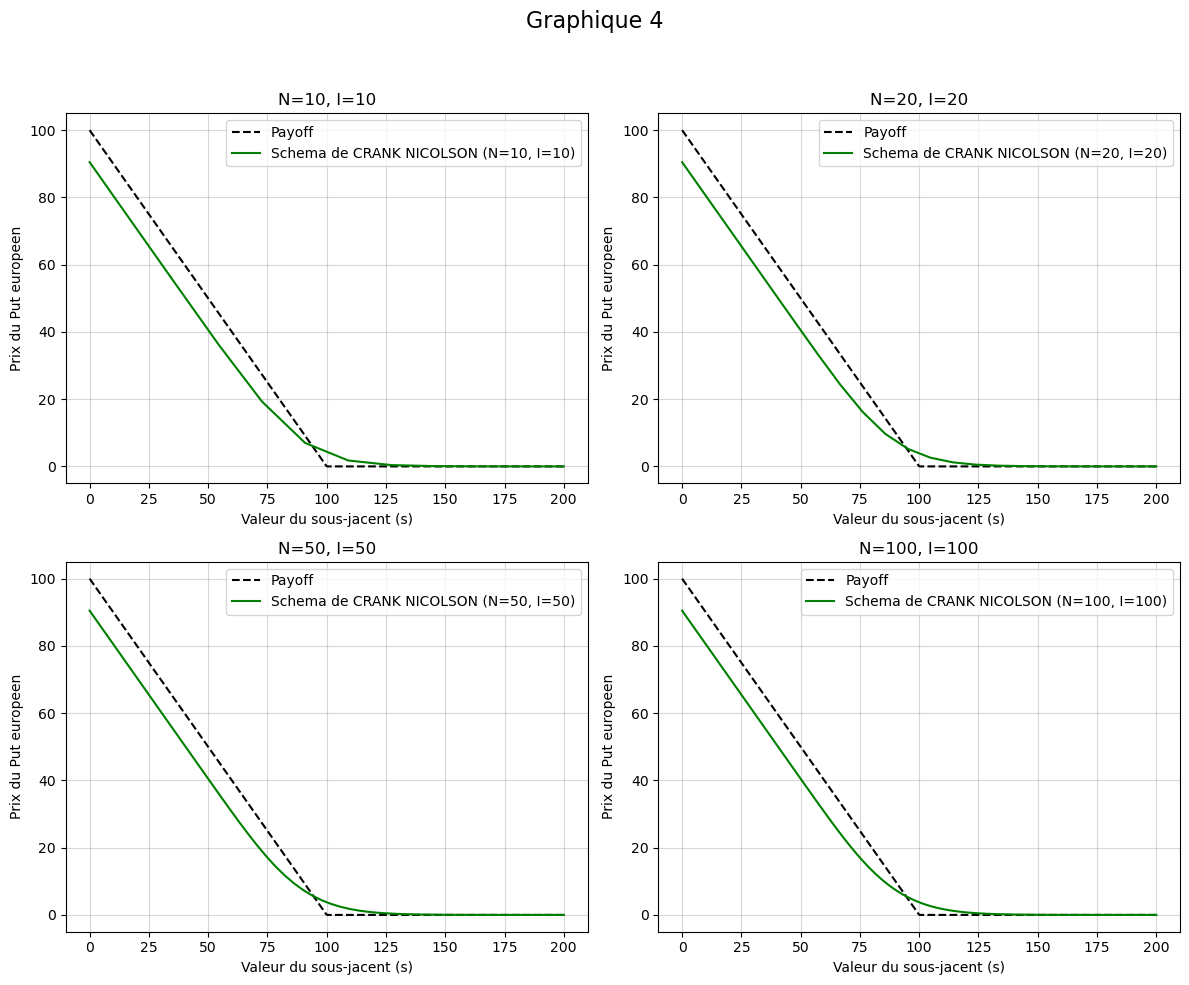

In [22]:
def plot_four_graphs():
    """
    Trace quatre graphiques représentant le payoff et la solution numérique
    pour différentes valeurs de N et I dans une seule figure.
    """
    # Paramètres pour les simulations
    params = [
        (10, 10),   # (N, I)
        (20, 20),  # (N, I)
        (50, 50), # (N, I)
        (100, 100)  # (N, I)
    ]
    
    # Créer la figure et les sous-graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Graphique 4', fontsize=16)
    
    # Générer les graphiques
    for i, (N, I) in enumerate(params):
        row, col = divmod(i, 2)  # Calculer la position (ligne, colonne) dans la grille
        s, U,_ = crank_nicolson(N, I)
        
        # Tracé du payoff
        S = np.linspace(Smin, Smax, 500)
        payoff_values = phi(S)
        axs[row, col].plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')
        
        # Tracé de la solution obtenue par Euler explicite
        axs[row, col].plot(s, U, label=f"Schema de CRANK NICOLSON (N={N}, I={I})", color='green')
        
        # Ajouter des titres, légendes et grilles
        axs[row, col].set_title(f'N={N}, I={I}')
        axs[row, col].grid(alpha=0.5)
        axs[row, col].legend()
        axs[row, col].set_xlabel('Valeur du sous-jacent (s)')
        axs[row, col].set_ylabel('Prix du Put europeen')
    # Ajuster l'espacement
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de la place pour le titre global
    plt.show()

# Exemple d'utilisation
plot_four_graphs()

**Commentaire:** Les graphiques ci-dessus relatifs au schéma de CRANK NICOLSON suggèrent que ce dernier est stable numériquement. Comme pour Euler implicite, il ne présente en effet pas d'explosion ou d'oscillation. 

#### b) Ordre du schéma de CRANK NICOLSON.

In [23]:
I_values = [10, 20, 40, 80, 160, 320]
table = []

for I in I_values:
    N = I

    # Mesure du temps d'exécution pour implicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = crank_nicolson(N, I)  # Appel de implicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout du temps d'exécution à la table

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

I         N         U(s)                errex               tcpu                alpha               error               
10        10        14.353451           1.079788            0.001469            N/A                 N/A                 
20        20        13.578892           0.305229            0.001086            1.953920            0.774559            
40        40        13.353140           0.079477            0.002742            2.011209            0.225752            
80        80        13.293944           0.020281            0.009764            2.005878            0.059195            
160       160       13.278788           0.005125            0.092298            2.002416            0.015156            
320       320       13.274951           0.001288            2.004515            2.001060            0.003837            


In [24]:
I_values = [10, 20, 40, 80, 160, 320]
table = []

for I in I_values:
    N = int(I/10)

    # Mesure du temps d'exécution pour implicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = crank_nicolson(N, I)  # Appel de implicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout du temps d'exécution à la table

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

I         N         U(s)                errex               tcpu                alpha               error               
10        1         14.230461           0.956798            0.000913            N/A                 N/A                 
20        2         13.506181           0.232518            0.000353            2.187701            0.724281            
40        4         13.334783           0.061120            0.000913            1.997041            0.171397            
80        8         13.288798           0.015135            0.001393            2.050009            0.045985            
160       16        13.277492           0.003829            0.009290            2.000797            0.011307            
320       32        13.274627           0.000964            0.092256            1.999440            0.002865            


**Commentaire:** Le graphique et les deux tableaux relatifs au schéma de CRANK NICOLSON suggèrent que ce dernier est stable numériquement. Comme pour Euler implicite, il ne présente en effet pas d'explosion ou d'oscillation. Plus le maillage en temps est épais, plus ce schéma semble vite converger.

#### f) Version sparse de Crank Nicolson
Dans cette section on essaye d'optimiser le temps d'exécution des schémas en ne calculant ue les termes non nuls de la matrice A qui apprait à chaque fois dans les équations récursives des différents schémas. On le fait en particulier pour le chéma de crank Nicolson qui est le meilleur des trois que nous avons programmés, car il est d'ordre 2 aussi bien en temps qu'en espace.

In [25]:
def crank_nicolson1(N, I):
    """
    Implémente le schéma de Crank-Nicolson en intégrant le fait que la matrice A soit sparse
    
    Paramètres :
        N (int) : Nombre de pas de temps.
        I (int) : Nombre de points spatiaux.
    Retourne :
        s (array) : Maillage spatial.
        U (array) : Solution numérique à t = T.
    """
    # Calcul des pas
    h = (Smax - Smin) / (I + 1)
    dt = T / N

    # Maillage spatial
    s = Smin + h * np.arange(1, I + 1)  # points s_1, ..., s_I


    # Initialisation de U
    U = phi(s).reshape(I, 1)

    # Coefficients pour la matrice tridiagonale
    alpha = (sigma**2 / 2) * (s**2 / h**2)
    beta = r * s / (2 * h)

    # Matrice A (pour t = n+1) et B (pour t = n)
    A = np.zeros((I, I))
    B = np.zeros((I, I))

    for i in range(I):
        if i > 0:
            A[i, i-1] = -alpha[i] + beta[i]
        A[i, i] = 2 * alpha[i] + r
        if i < I - 1:
            A[i, i+1] = -alpha[i] - beta[i]
            
    # Matrice Id - dt * A
    B = np.eye(I) - (dt/2) * A 
    C = np.eye(I) + (dt/2) * A 
    
    # Fonction q(t)
    def q(t):
        q_vec = np.zeros((I, 1))
        q_vec[0] = 0.5 * (-alpha[0] + beta[0]) * (u_left(t) + u_left(t - dt))
        q_vec[-1] = 0.5 * (-alpha[-1] - beta[-1]) * (u_right(t) + u_right(t - dt))
        return q_vec

    # Boucle temporelle pour le schéma de Crank-Nicolson
    for n in range(N):
        tn = (n + 1) * dt
        rhs = B @ U - dt*q(tn)  # Second membre
        U = spsolve(C, rhs)  # Résolution du système linéaire
        U = U.reshape(I, 1)

    # Ajouter les conditions aux limites pour compléter le graphique
    s = s.tolist()
    s.insert(0, Smin)
    s.append(Smax)

    U = U.flatten().tolist()
    U.insert(0, u_left(T))
    U.append(0)

    return s, U, A

In [26]:
I_values = [10, 20, 40, 80, 160, 320]
table = []

for I in I_values:
    N = I

    # Mesure du temps d'exécution pour implicit_euler
    start_time = time.time()  # Démarre le chronomètre
    s, U, _ = crank_nicolson1(N, I)  # Appel de implicit_euler
    end_time = time.time()  # Arrête le chronomètre

    tcpu = end_time - start_time  # Temps écoulé en secondes

    U_val = interpolate(s, U, I, S_val)
    exact_val = black_scholes_put(S_val, K, T, r, sigma)  # Formule exacte
    errex = abs(U_val - exact_val)  # Erreur exacte
    table.append([I, N, U_val, errex, tcpu])  # Ajout du temps d'exécution à la table

# Calcul des erreurs successives et ordres de convergence
for k in range(1, len(table)):
    # Déballer les 5 premières colonnes
    I_prev, N_prev, U_prev, errex_prev, _ = table[k - 1][:5]
    I_curr, N_curr, U_curr, errex_curr, _ = table[k][:5]

    # Calcul des tailles de maillage
    h_prev = (Smax - Smin) / (I_prev + 1)
    h_curr = (Smax - Smin) / (I_curr + 1)

    # Calcul de l'ordre alpha
    alpha = np.log(errex_prev / errex_curr) / np.log(h_prev / h_curr)
    if len(table[k]) == 5:  # Ajouter alpha seulement si elle n'existe pas
        table[k].append(alpha)

    # Calcul de l'erreur entre U(s) successifs
    error = abs(U_curr - U_prev)
    if len(table[k]) == 6:  # Ajouter l'erreur seulement si elle n'existe pas
        table[k].append(error)

# Affichage du tableau avec 6 chiffres après la virgule
print(f"{'I':<10}{'N':<10}{'U(s)':<20}{'errex':<20}{'tcpu':<20}{'alpha':<20}{'error':<20}")
for row in table:
    I = row[0]
    N = row[1]
    U = row[2]
    errex = row[3]
    tcpu = row[4]
    alpha = row[5] if len(row) > 5 else 'N/A'
    error = row[6] if len(row) > 6 else 'N/A'

    # Vérifier si alpha et error sont numériques avant d'appliquer le formatage
    alpha_str = f"{alpha:<20.6f}" if isinstance(alpha, (int, float)) else f"{alpha:<20}"
    error_str = f"{error:<20.6f}" if isinstance(error, (int, float)) else f"{error:<20}"

    # Formatage avec 6 chiffres après la virgule pour les nombres
    print(f"{I:<10}{N:<10}{U:<20.6f}{errex:<20.6f}{tcpu:<20.6f}{alpha_str}{error_str}")

/tmp/ipykernel_37613/748617567.py:53: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U = spsolve(C, rhs)  # Résolution du système linéaire


I         N         U(s)                errex               tcpu                alpha               error               
10        10        14.353451           1.079788            0.003580            N/A                 N/A                 
20        20        13.578892           0.305229            0.003644            1.953920            0.774559            
40        40        13.353140           0.079477            0.007727            2.011209            0.225752            
80        80        13.293944           0.020281            0.018718            2.005878            0.059195            
160       160       13.278788           0.005125            0.066744            2.002416            0.015156            
320       320       13.274951           0.001288            0.847080            2.001060            0.003837            


**Commentaire:** On comparant ce tableau à celui obtenu plus haut pour le schéma de crank Nicolson dans le cas N=I, on voit qu'en utilisant le fait que la matrice A est creuse, on a un véritable gain dans le temps d'éxécution pour de grandes valeurs de N et de I. 

### 4-CAS D'UN CALL EUROPEEN
Le prix du call européen est solution de l'EDP ci-après :
\begin{cases}
\frac{\partial v}{\partial t} - \frac{\sigma^2}{2} s^2 \frac{\partial^2 v}{\partial s^2} - rs \frac{\partial v}{\partial s} + rv = 0, & t \in (0, T), s \in (S_{\text{min}}, S_{\text{max}}), \\
v(t, S_{\text{min}}) = v_\ell(t) \equiv 0, & t \in (0, T), \\
v(t, S_{\text{max}}) = v_r(t) \equiv S_{\text{max}} - K e^{-r(T-t)}, & t \in (0, T), \\
v(0, s) = \phi(s) := \max(s - K, 0), & s \in (S_{\text{min}}, S_{\text{max}}).
\end{cases}

On va implémenter et tester dans la suite le schéma d'Euler implicite dans le cas du call européen. 

In [27]:
def phi_call(s):
    """Fonction de payoff pour un call européen."""
    return np.maximum(s - K, 0).reshape(-1, 1)

def u_left_call(t):
    """Condition limite gauche v(t, Smin)."""
    return 0

def u_right_call(t):
    """Condition limite droite v(t, Smax)."""
    return Smax - K * np.exp(-r * t)

def build_matrices(I, h, dt):
    s = Smin + h * np.arange(1, I + 1)
    alpha = (sigma**2 / 2) * (s**2 / h**2)
    beta = r * s / (2 * h)
    
    A = np.zeros((I, I))
    for i in range(I):
        if i > 0:
            A[i, i-1] = -alpha[i] + beta[i]

        A[i, i] = 2 * alpha[i] + r

        if i < I - 1:
            A[i, i+1] = -alpha[i] - beta[i]
    
    return s, alpha, beta, A

def implicit_euler_call(N, I):
    """
    Implémente le schéma d'Euler implicite pour un call européen.
    """
    h = (Smax - Smin) / (I + 1)
    dt = T / N
    s, alpha, beta, A = build_matrices(I, h, dt)
    U = phi_call(s).reshape(I, 1)
    B = np.eye(I) + dt * A

    def q(t):
        q_vec = np.zeros((I, 1))
        q_vec[0] = (-alpha[0] + beta[0]) * u_left_call(t)
        q_vec[-1] = (-alpha[-1] - beta[-1]) * u_right_call(t)
        return q_vec

    for n in range(N):
        tn = (n + 1) * dt
        U = solve(B, U - dt * q(tn))

    s = s.tolist()
    s.insert(0, Smin)
    s.append(Smax)
    U = U.flatten().tolist()
    U.insert(0, u_left_call(T))
    U.append(u_right_call(T))
    
    return s, U, A

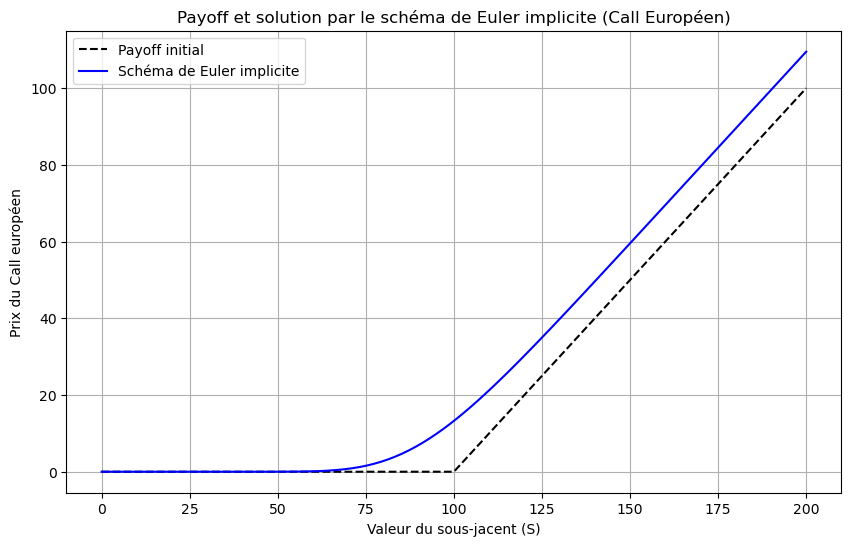

In [28]:
def plot_results_call(method, N, I, method_name):
    """
    Trace le payoff initial et la solution obtenue avec une méthode donnée pour un call européen.
    """
    s, U, _ = method(N, I)
    S = np.linspace(Smin, Smax, 500)
    payoff_values = phi_call(S)

    plt.figure(figsize=(10, 6))
    plt.plot(S, payoff_values, label="Payoff initial", color="black", linestyle="--")
    plt.plot(s, U, label=f"Schéma de {method_name}", color="blue")
    plt.title(f"Payoff et solution par le schéma de {method_name} (Call Européen)")
    plt.xlabel("Valeur du sous-jacent (S)")
    plt.ylabel("Prix du Call européen")
    plt.grid(True)
    plt.legend()
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    N = 100  # Nombre de pas de temps
    I = 100  # Nombre de points spatiaux

    # Plot pour Euler implicite (Call Européen)
    plot_results_call(implicit_euler_call, N, I, "Euler implicite")

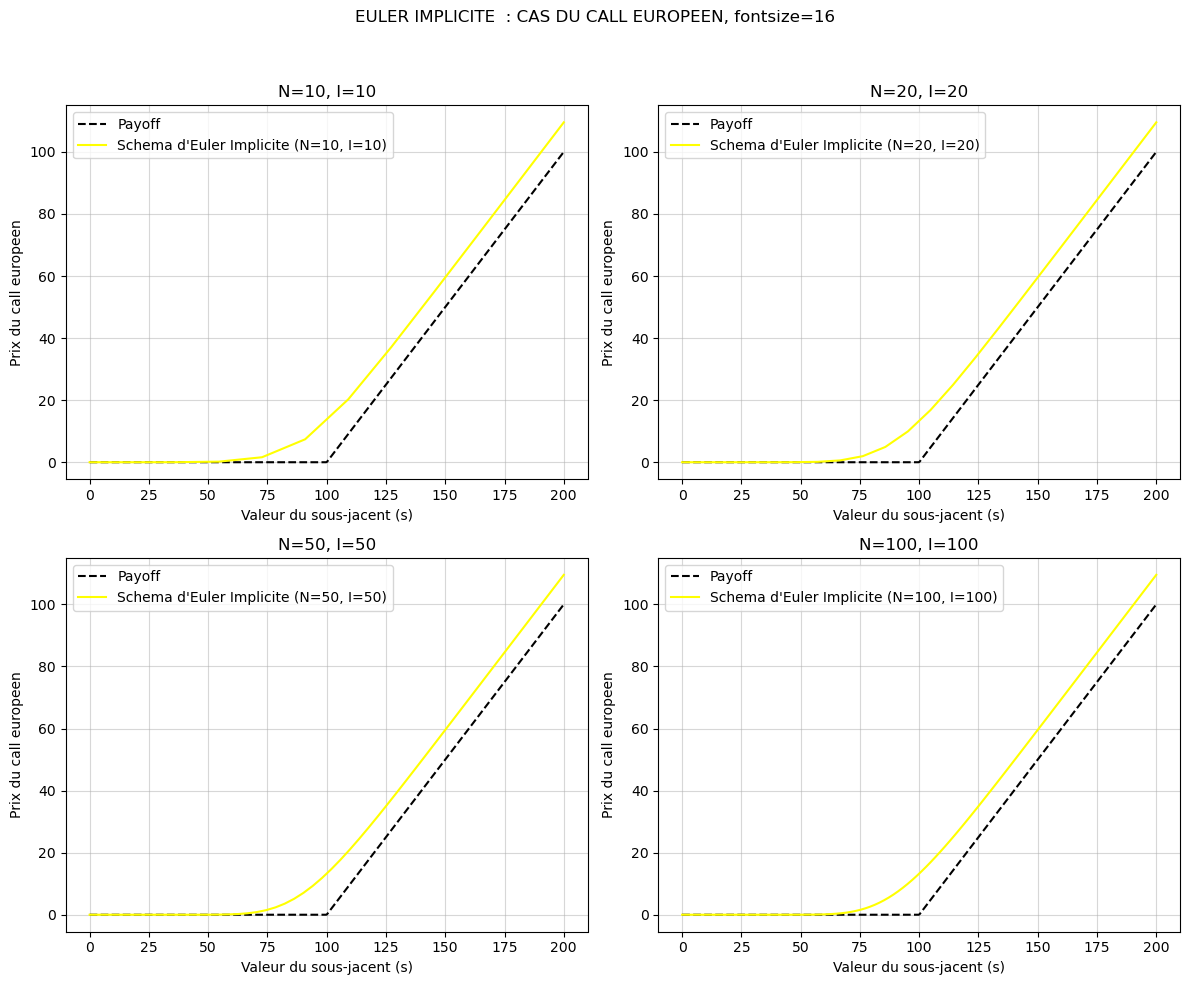

In [29]:
def plot_four_graphs():
    """
    Trace quatre graphiques représentant le payoff et la solution numérique
    pour différentes valeurs de N et I dans une seule figure.
    """
    # Paramètres pour les simulations
    params = [
        (10, 10),   # (N, I)
        (20, 20),  # (N, I)
        (50, 50), # (N, I)
        (100, 100)  # (N, I)
    ]
    
    # Créer la figure et les sous-graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('EULER IMPLICITE  : CAS DU CALL EUROPEEN, fontsize=16')
    
    # Générer les graphiques
    for i, (N, I) in enumerate(params):
        row, col = divmod(i, 2)  # Calculer la position (ligne, colonne) dans la grille
        s, U,_ = implicit_euler_call(N, I)
        
        # Tracé du payoff
        S = np.linspace(Smin, Smax, 500)
        payoff_values = phi_call(S)
        axs[row, col].plot(S, payoff_values, label=r'Payoff', color='black', linestyle='--')
        
        # Tracé de la solution obtenue par Euler explicite
        axs[row, col].plot(s, U, label=f"Schema d'Euler Implicite (N={N}, I={I})", color='yellow')
        
        # Ajouter des titres, légendes et grilles
        axs[row, col].set_title(f'N={N}, I={I}')
        axs[row, col].grid(alpha=0.5)
        axs[row, col].legend()
        axs[row, col].set_xlabel('Valeur du sous-jacent (s)')
        axs[row, col].set_ylabel('Prix du call europeen')
    # Ajuster l'espacement
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de la place pour le titre global
    plt.show()

# Exemple d'utilisation
plot_four_graphs()

**Commentaire:** On peut voir que comme dans le cas du Put le schéma d'euler implicite est encore stable numériquement. 